In [1]:
import numpy as np
from numpy.linalg import cholesky


In [100]:
def log_gaussian(x, mean, cov):
    d = len(x)
    L = cholesky(cov)
    diff = x - mean
    sol = np.linalg.solve(L, diff)
    return -0.5 * np.dot(sol, sol) - np.sum(np.log(np.diag(L))) - 0.5 * d * np.log(2*np.pi)

def simulate_lgssm(A, H, Q, R, x0, T):
    d_x = len(x0)
    d_y = H.shape[0]
    X = np.zeros((T+1, d_x))
    Y = np.zeros((T,d_y))

    X[0] = x0
    for k in range(T):
        X[k+1] = A @ X[k] + np.random.multivariate_normal(np.zeros(d_x), Q)
        Y[k] = H @ X[k+1] + np.random.multivariate_normal(np.zeros(d_y), R)

    return X, Y

A = np.array([[1,0.1],[-0.1,1]])
H = np.eye(2)
Q = 0.000*np.eye(2)
R = 0.000001*np.eye(2)
x0 = np.array([[1],[1]]).reshape((2,))
T = 5

X, Y = simulate_lgssm(A, H, Q, R, x0, T)

X, Y


(array([[1.     , 1.     ],
        [1.1    , 0.9    ],
        [1.19   , 0.79   ],
        [1.269  , 0.671  ],
        [1.3361 , 0.5441 ],
        [1.39051, 0.41049]]),
 array([[1.09846275, 0.89918639],
        [1.18999337, 0.78866074],
        [1.26748972, 0.67149737],
        [1.33608041, 0.54390338],
        [1.39073488, 0.41005868]]))

In [162]:
from tqdm import tqdm 

def MHMCfilter_linear(Y, m0, P0, A, H, Q, R, S, N=1000):
    d_x = A.shape[0]
    d_y = H.shape[0]
    T = Y.shape[0]
    samples_e = np.zeros((N, T+1, d_x))
    samples_o = np.zeros((N, T+1, d_x))

    def log_predictive(x, samples_o_t, A, Q):
        logs = np.array([
            log_gaussian(x, A @ samples_o_t[i], Q)
            for i in range(samples_o_t.shape[0])
        ])
        m = np.max(logs)
        return m + np.log(np.mean(np.exp(logs - m)))



    # Inicializar la cadena de Markov
    samples_e[0,0] = np.random.multivariate_normal(m0, P0)
    samples_o[0,0] = np.random.multivariate_normal(m0, P0)
    for t in range(T):
        ## Evolución
        xt_samples = samples_o[:,t,:]
        for s in range(N):
            m_t = A @ xt_samples[s]
            samples_e[s,t+1,:] = np.random.multivariate_normal(m_t, Q)
        ## Predicción
        y = Y[t]

        for s in tqdm(range(N),desc=f"Tiempo {t}/{T}"):
            x = samples_e[s,t+1,:]
            ll_current = log_gaussian(y, H @ x, R)
            lp_current = log_predictive(x, samples_o[:,t,:], A, Q)

            samples_mh = np.zeros((N, d_x))
            for l in range(N):
                # Propuesta
                x_prop = np.random.multivariate_normal(x, S)
                # Cálculo de la aceptación
                ll_proposed = log_gaussian(y, H @ x_prop, R)
                lp_proposed = log_predictive(x_prop, samples_o[:,t,:], A, Q)
                log_alpha = (ll_proposed + lp_proposed) - (ll_current + lp_current)
                if np.log(np.random.uniform()) < log_alpha: # Aceptación
                    samples_mh[l,:] = x_prop
                    ll_current = ll_proposed
                    lp_current = lp_proposed
                else: # Rechazo
                    samples_mh[l,:] = x
            # Actualizar la cadena de Markov
            samples_o[s,t+1,:] = samples_mh[-1,:]

    return samples_e, samples_o



A = np.array([[1.05]])
H = np.eye(1)
Q = 0.001*np.eye(1)
R = 0.1*np.eye(1)
x0 = np.array([[1]]).reshape((1,))
T = 12

X, Y = simulate_lgssm(A, H, Q, R, x0, T)


results = MHMCfilter_linear(Y, x0, 0.001*np.eye(1), A, H, Q, R, 0.1*np.eye(1),15)

Tiempo 0/12:   0%|          | 0/15 [00:00<?, ?it/s]

Tiempo 11/12: 100%|██████████| 15/15 [00:00<00:00, 63.87it/s]


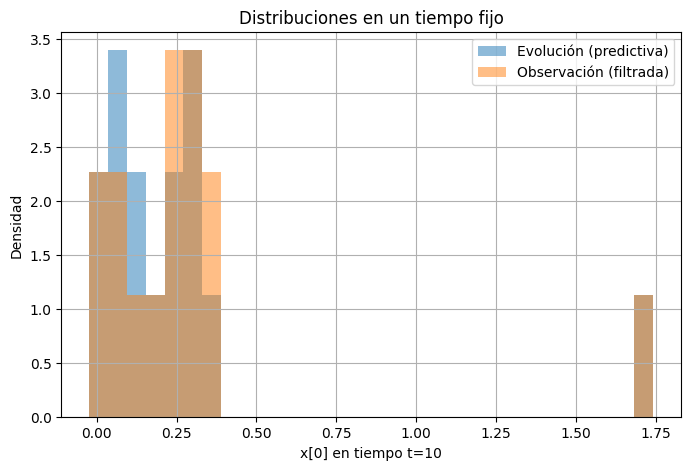

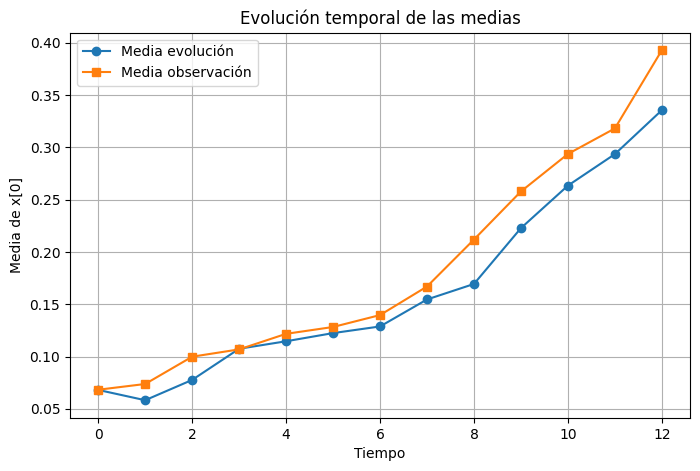

In [163]:
import matplotlib.pyplot as plt

def plot_hist_evolution_observation(samples_e, samples_o, t, dim=0, bins=30):
    """
    Histogramas de:
    - distribución predictiva (evolución)
    - distribución filtrada (observación)
    en un tiempo fijo t y dimensión dim
    """
    x_e = samples_e[:, t, dim]
    x_o = samples_o[:, t, dim]

    plt.figure(figsize=(8,5))
    plt.hist(x_e, bins=bins, density=True, alpha=0.5, label="Evolución (predictiva)")
    plt.hist(x_o, bins=bins, density=True, alpha=0.5, label="Observación (filtrada)")
    plt.xlabel(f"x[{dim}] en tiempo t={t}")
    plt.ylabel("Densidad")
    plt.legend()
    plt.title("Distribuciones en un tiempo fijo")
    plt.grid(True)
    plt.show()

plot_hist_evolution_observation(results[0], results[1], t=10, dim=0)

def plot_means_over_time(samples_e, samples_o, dim=0):
    """
    Media de la evolución y de la observación
    a lo largo del tiempo para una dimensión fija.
    """
    T = samples_e.shape[1]

    mean_e = np.mean(samples_e[:, :, dim], axis=0)
    mean_o = np.mean(samples_o[:, :, dim], axis=0)

    plt.figure(figsize=(8,5))
    plt.plot(range(T), mean_e, '-o', label="Media evolución")
    plt.plot(range(T), mean_o, '-s', label="Media observación")
    plt.xlabel("Tiempo")
    plt.ylabel(f"Media de x[{dim}]")
    plt.legend()
    plt.title("Evolución temporal de las medias")
    plt.grid(True)
    plt.show()

plot_means_over_time(results[0], results[1], dim=0)
